In [1]:
ask = True
if ask:
  !pip install qiskit
  !pip install qiskit qiskit-aer
  !pip install qiskit[visualization]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 121.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=bb7a79f43839d6e32549f34337e75b19c370fa8161bd0885cc5cce238e4921cb
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit_aer import Aer
import numpy as np

In [3]:
m = [2,1,0,2,1,0,0,0,0]

In [4]:
# This function prepares empty_cell which stores index of qubits with empty cells
empty_cell = []
def prepare_empty_cell(m, empty_cell):
  empty_cell.clear() # Clear the list before populating
  j = 0
  for i in range(9):
    if(m[i]  == 0):
      empty_cell.append(j)
      empty_cell.append(j+1)
    j = j+2
prepare_empty_cell(m, empty_cell)
print(empty_cell)

[4, 5, 10, 11, 12, 13, 14, 15, 16, 17]


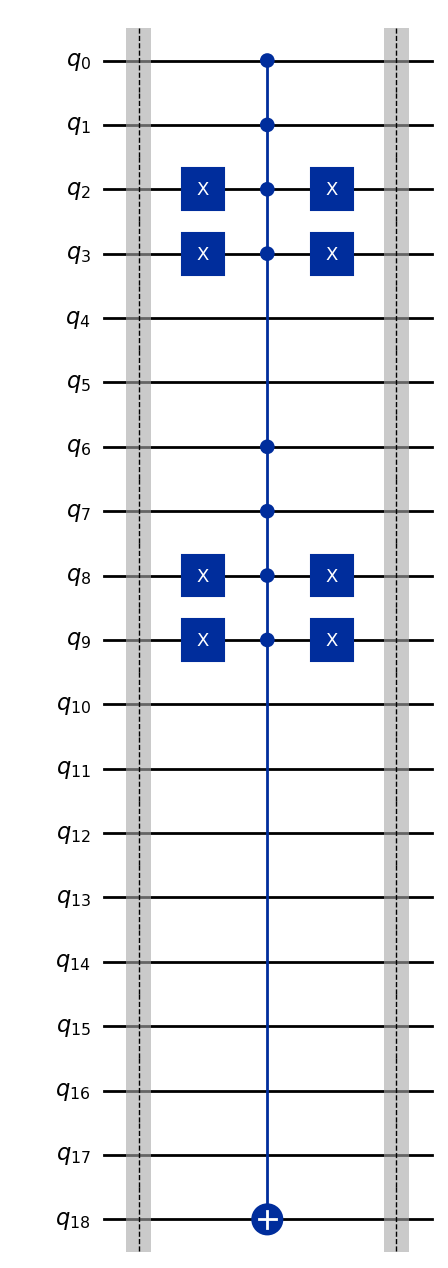

In [5]:
'''
This function will take in the board state as a list. And it will create a block of quantum circuit, that will take in all the possible superposition of states and return 1 in the 19th qubit if the board is the same as the
given board, or 0 if not.
'''
#Here what i wnat to do is just apply the gates on qubits that are not in the lsit of empty cell. Which are the places where m = 2,1.
def make_board(m):
  block = QuantumCircuit(19,name="Given Board")
  block.barrier()
  i = 0
  j = 0
  while(i<9):
    # So when m[i] = 0 this means the cell is empty and I dont have to take it into consideration since this oracle function only checks for the cases where the cells is occupied by 1's or 2's.
    # And when m[i] = 1, this means the cells is occupied by and "0" which is |00> and thus to check for that i will have to apply two NOT gate to make it |11> and then could be used as control qubit.
    # For m[i] = 2 this means we have an "X" at that position which maps to |11> and this doesnt require anything to be applied before using it as controlled qubit.
    # if(m[i]  == 0):
    #   empty_cell.append(j)
    #   empty_cell.append(j+1)
    #   block.x(j+1)
    if(m[i] == 1):
      block.x(j)
      block.x(j+1)
    j = j+2
    i = i+1

# Controlled qubit must contain the index number of all the qubits that are not empty.

  controls = list(range(18))
  controls = list(set(controls) - set(empty_cell))
  target = 18
  block.mcx(controls, target)

  i = 0
  j = 0
  while(i<9):
    # if(m[i]  == 0):
    #   block.x(j+1)
    if(m[i] == 1):
      block.x(j)
      block.x(j+1)
    j = j+2
    i = i+1
  block.barrier()
  return block


block = make_board(m)
block.draw(output='mpl')

In [6]:
# This function will calculate the no of possiblites of the game's next move
def no_of_possibilites(m_dash):
  count = 0
  for i in range(9):
    if(m_dash[i] == 0):
      count = count + 1
  return count

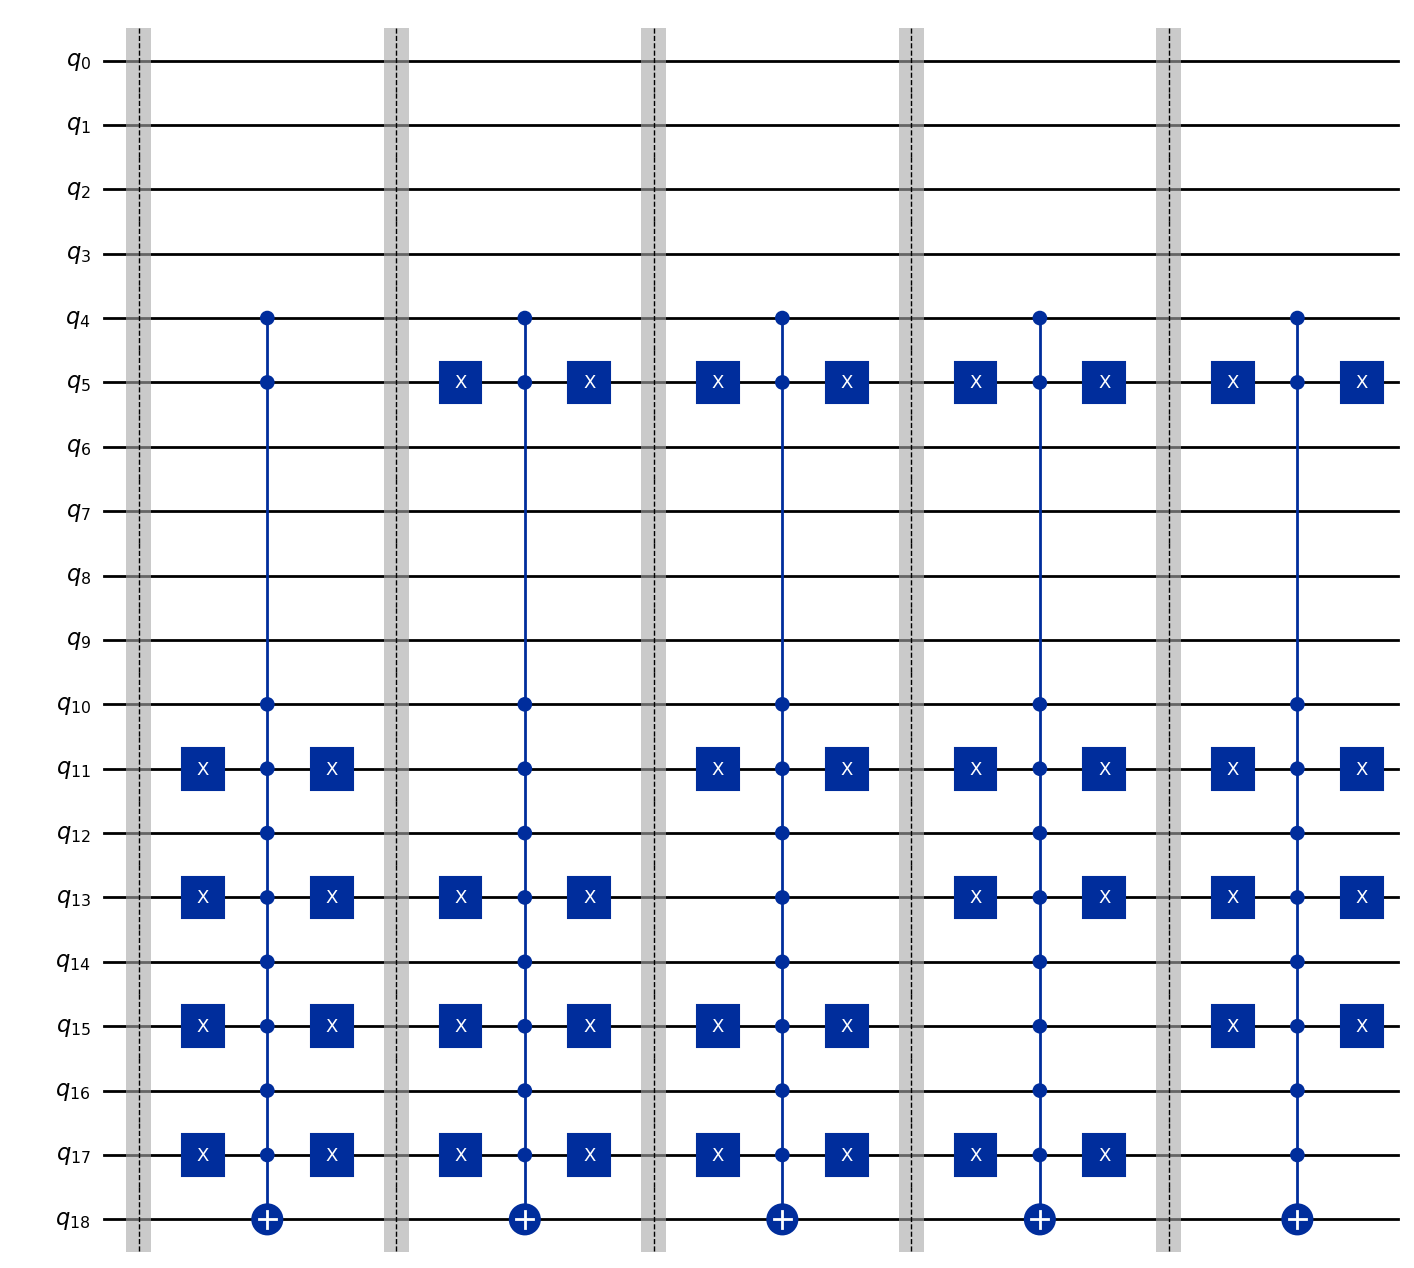

In [7]:
def game_tree(n,empty_cell):
  block = QuantumCircuit(19,name="Game Tree")
  i = 0
  while(i<n):# if the possiblities is 5
    block.barrier()
    control_qubits = []
    j = 0
    while(j<2*n):# then the elements inside the empty_cell will be 10

      if(j!=2*i):
        block.x(empty_cell[j+1])
        control_qubits.append(empty_cell[j])
        control_qubits.append(empty_cell[j+1])
      else:
        control_qubits.append(empty_cell[j])
        control_qubits.append(empty_cell[j+1])
      j = j + 2

    block.mcx(control_qubits ,18)

    j = 0
    while(j<2*n):# then the elements inside the empty_cell will be 10

      if(j!=2*i):

        block.x(empty_cell[j+1])
      j = j + 2

    i = i + 1
  return block

block1 = game_tree(no_of_possibilites(m),empty_cell)
block1.draw(output='mpl')

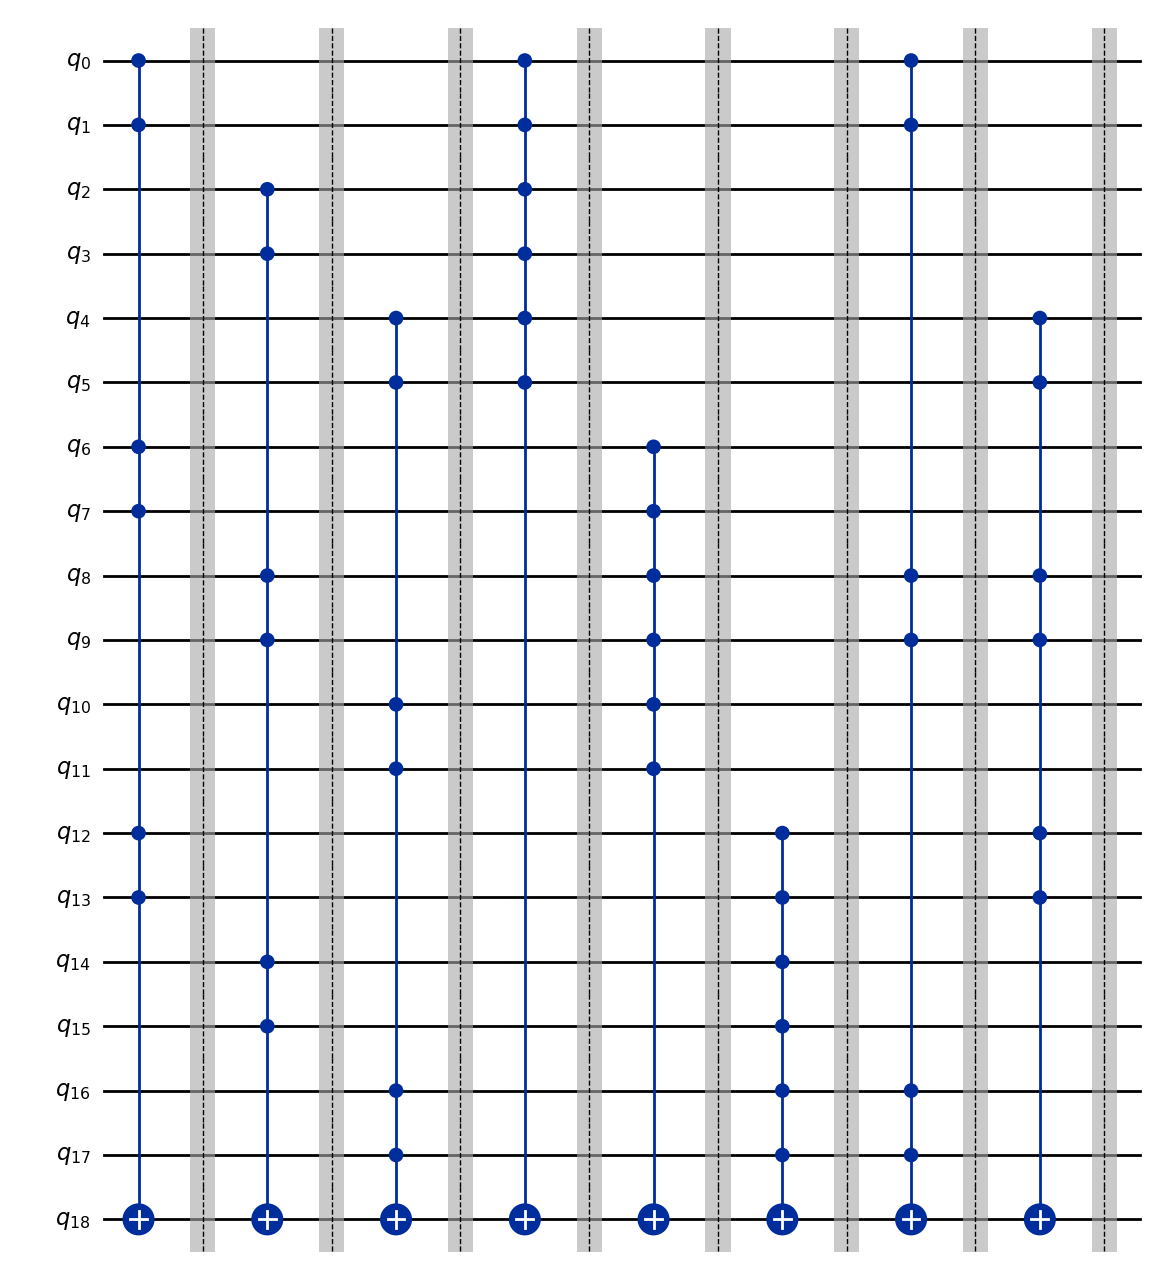

In [8]:
def x_is_winning_next_move():
  qc_combined_X_wins = QuantumCircuit(19,name="X wins")

  # This circuit will have 18 qubits which will recive the superposition of all the possible outcomes, and 1 qubit for storing the value of 'f' which wil be output to be used.
  # and later after computation we will be required to have 1 classical bit to store the 'f' value of 19th qubit.

  # If cell 1,4,7 is filled with X
  qc_combined_X_wins.mcx([0,1,6,7,12,13],18)
  qc_combined_X_wins.barrier()

  # If cell 2,5,8 is filled with X
  qc_combined_X_wins.mcx([2,3,8,9,14,15],18)
  qc_combined_X_wins.barrier()

  # If cell 3,6,9 is filled with X
  qc_combined_X_wins.mcx([4,5,10,11,16,17],18)
  qc_combined_X_wins.barrier()

  # If cell 1,2,3 is with X
  qc_combined_X_wins.mcx([0,1,2,3,4,5],18)
  qc_combined_X_wins.barrier()

  # If cell 4,5,6 is filled with X
  qc_combined_X_wins.mcx([6,7,8,9,10,11],18)
  qc_combined_X_wins.barrier()

  # If cell 7,8,9 is filled with X
  qc_combined_X_wins.mcx([12,13,14,15,16,17],18)
  qc_combined_X_wins.barrier()

  # If cell 1,5,9 is filled with X
  qc_combined_X_wins.mcx([0,1,8,9,16,17],18)
  qc_combined_X_wins.barrier()

  # If cell 3,5,7 is filled with X
  qc_combined_X_wins.mcx([4,5,8,9,12,13],18)
  qc_combined_X_wins.barrier()

  return qc_combined_X_wins

block2 = x_is_winning_next_move()
block2.draw(output='mpl')


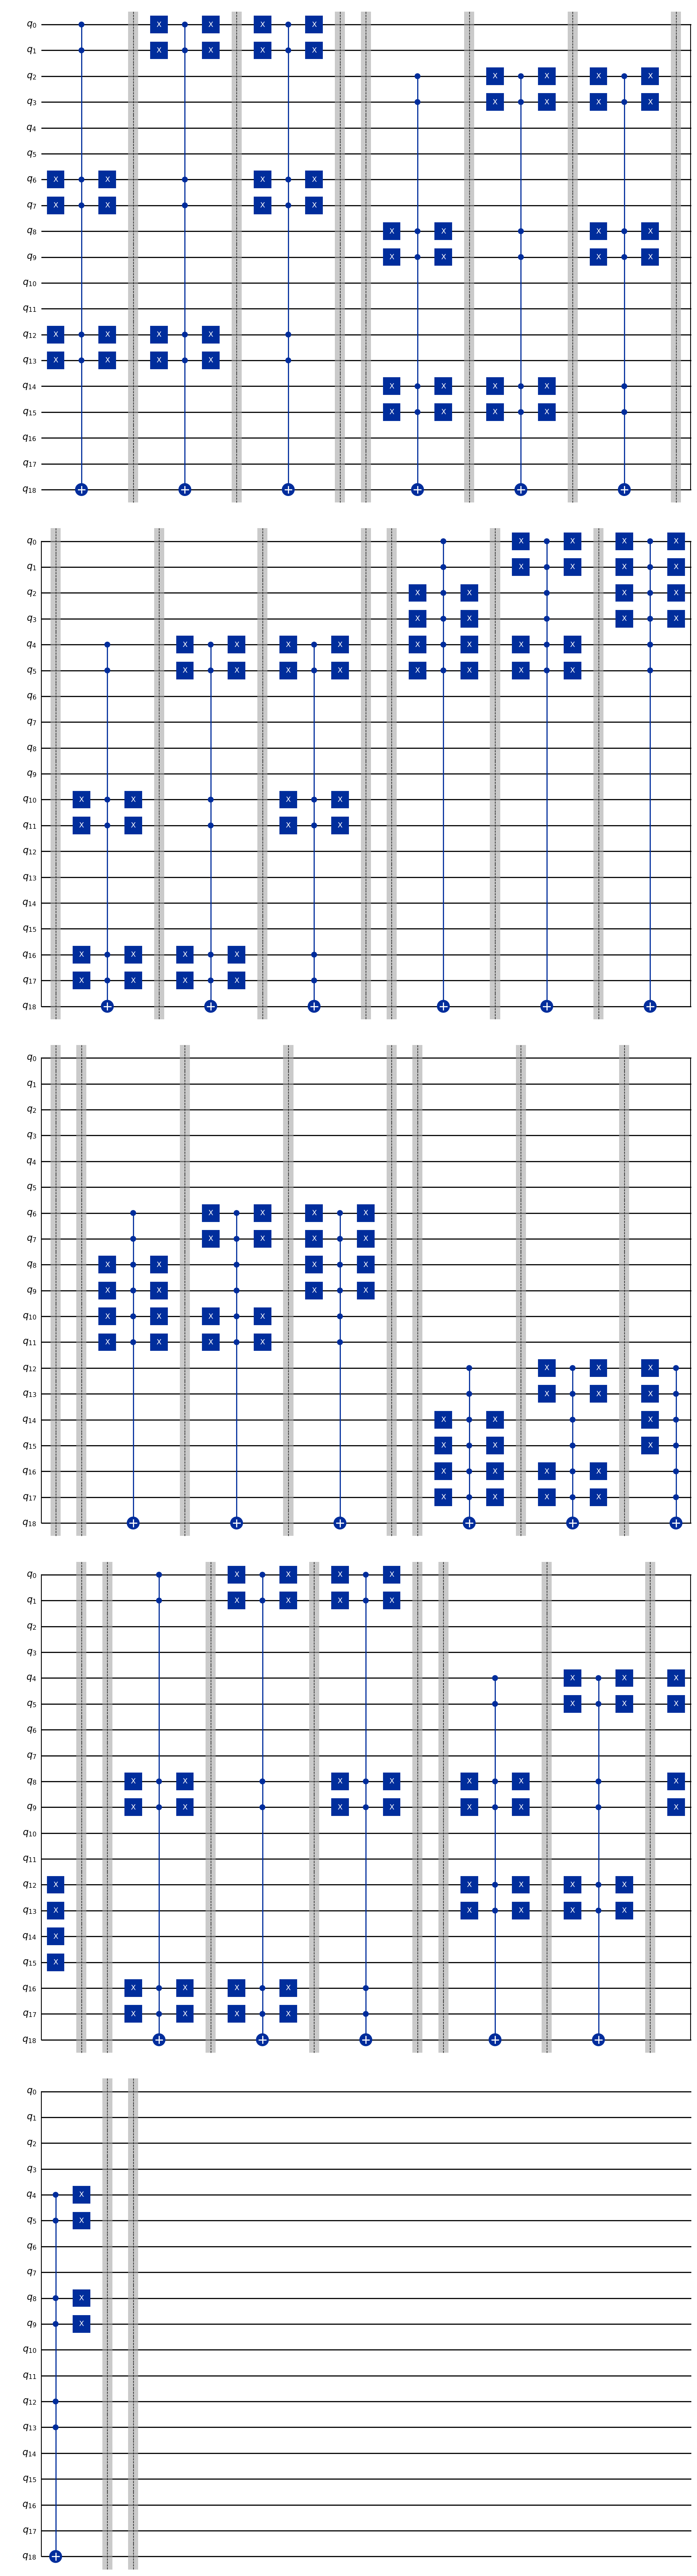

In [9]:
def o_is_winning_next_move():
  qc_combined_stop_O_from_wininng = QuantumCircuit(19,name="Stop O from winning")

  # this function will take in a list of six numbers which will be the qubit, that we want to apply this OOX,OXO,XOO.
  def stop_O_from_winning(array,qc_in_function):
    j = 0
    while(j<6):
      i = 0
      while(i<6):
        if(j!=i):
          qc_in_function.x(array[i])
          qc_in_function.x(array[i+1])
        i = i+2

      qc_in_function.mcx(array,18)

      i = 0
      while(i<6):
        if(j!=i):
          qc_in_function.x(array[i])
          qc_in_function.x(array[i+1])
        i = i+2
      j = j+2
      qc_in_function.barrier()
    qc_in_function.barrier()

  # Check if 1,4,7
  stop_O_from_winning([0,1,6,7,12,13],qc_combined_stop_O_from_wininng)

  # Check if 2,5,8
  stop_O_from_winning([2,3,8,9,14,15],qc_combined_stop_O_from_wininng)

  # Check if 3,6,9
  stop_O_from_winning([4,5,10,11,16,17],qc_combined_stop_O_from_wininng)

  #Check if 1,2,3
  stop_O_from_winning([0,1,2,3,4,5],qc_combined_stop_O_from_wininng)

  #Check if 4,5,6
  stop_O_from_winning([6,7,8,9,10,11],qc_combined_stop_O_from_wininng)

  #Check if 7,8,9
  stop_O_from_winning([12,13,14,15,16,17],qc_combined_stop_O_from_wininng)

  #Check if 1,5,9
  stop_O_from_winning([0,1,8,9,16,17],qc_combined_stop_O_from_wininng)

  #Check if 3,5,7
  stop_O_from_winning([4,5,8,9,12,13],qc_combined_stop_O_from_wininng)

  return qc_combined_stop_O_from_wininng

block3 = o_is_winning_next_move()
block3.draw(output='mpl')


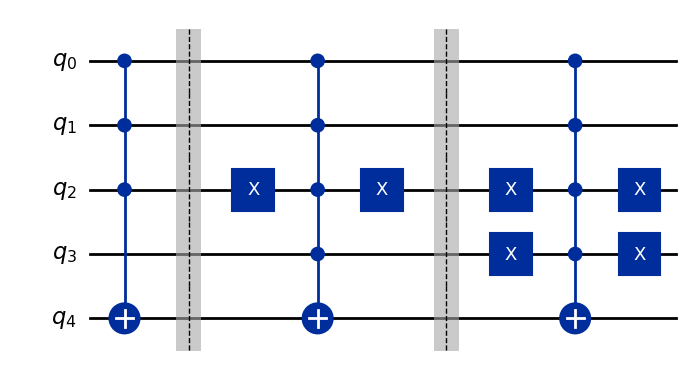

In [10]:
def final_oracle():
    qc = QuantumCircuit(5, name="Conditional Circuit")
    c0, c1, c2, c3, a = 0, 1, 2, 3, 4

    # ----- CASE 1 -----
    qc.mcx([c0, c1, c2], a)
    qc.barrier()

    # ----- CASE 2 -----
    qc.x(c2)
    qc.mcx([c0, c1, c2, c3], a)
    qc.x(c2)
    qc.barrier()

    # ----- CASE 3 -----
    qc.x(c2)
    qc.x(c3)
    qc.mcx([c0, c1, c2, c3], a)
    qc.x(c3)
    qc.x(c2)

    return qc

oracle = final_oracle()
oracle.draw("mpl")



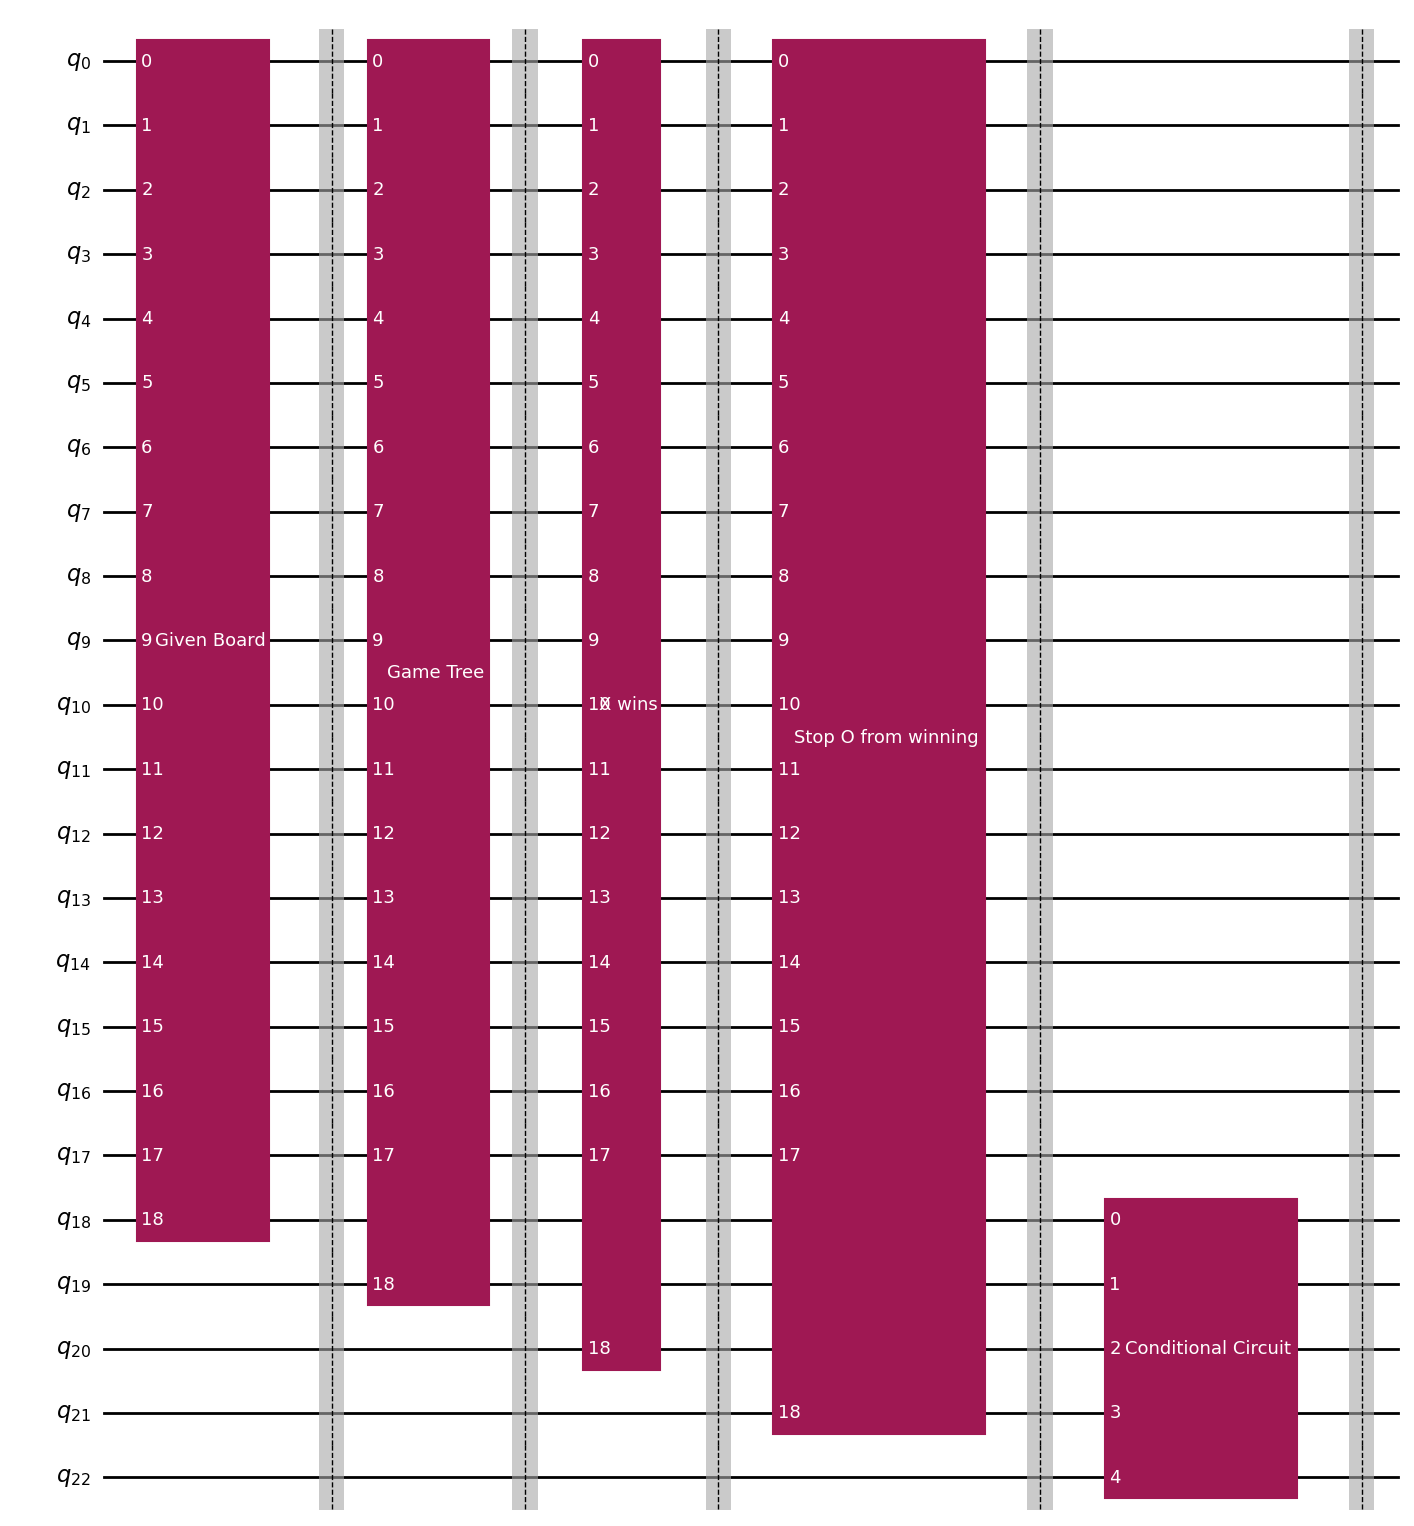

In [11]:
def oracle():
  qc_dash = QuantumCircuit(23,name="oracle")
  qc_board_maker = make_board(m)
  qc_game_tree = game_tree(no_of_possibilites(m), empty_cell)
  qc_x_wins_checker = x_is_winning_next_move()
  qc_x_looses_checker = o_is_winning_next_move()
  final_oracle_checker = final_oracle()




  qc_dash.append(qc_board_maker,list(range(19)))
  qc_dash.barrier()
  qc_dash.append(qc_game_tree,list(range(18))+list(range(19,20)))
  qc_dash.barrier()
  qc_dash.append(qc_x_wins_checker,list(range(18))+list(range(20,21)))
  qc_dash.barrier()
  qc_dash.append(qc_x_looses_checker,list(range(18))+list(range(21,22)))
  qc_dash.barrier()
  qc_dash.append(final_oracle_checker,list(range(18,23)))
  qc_dash.barrier()
  return qc_dash

qc_ex = oracle()
qc_ex.draw(output='mpl')

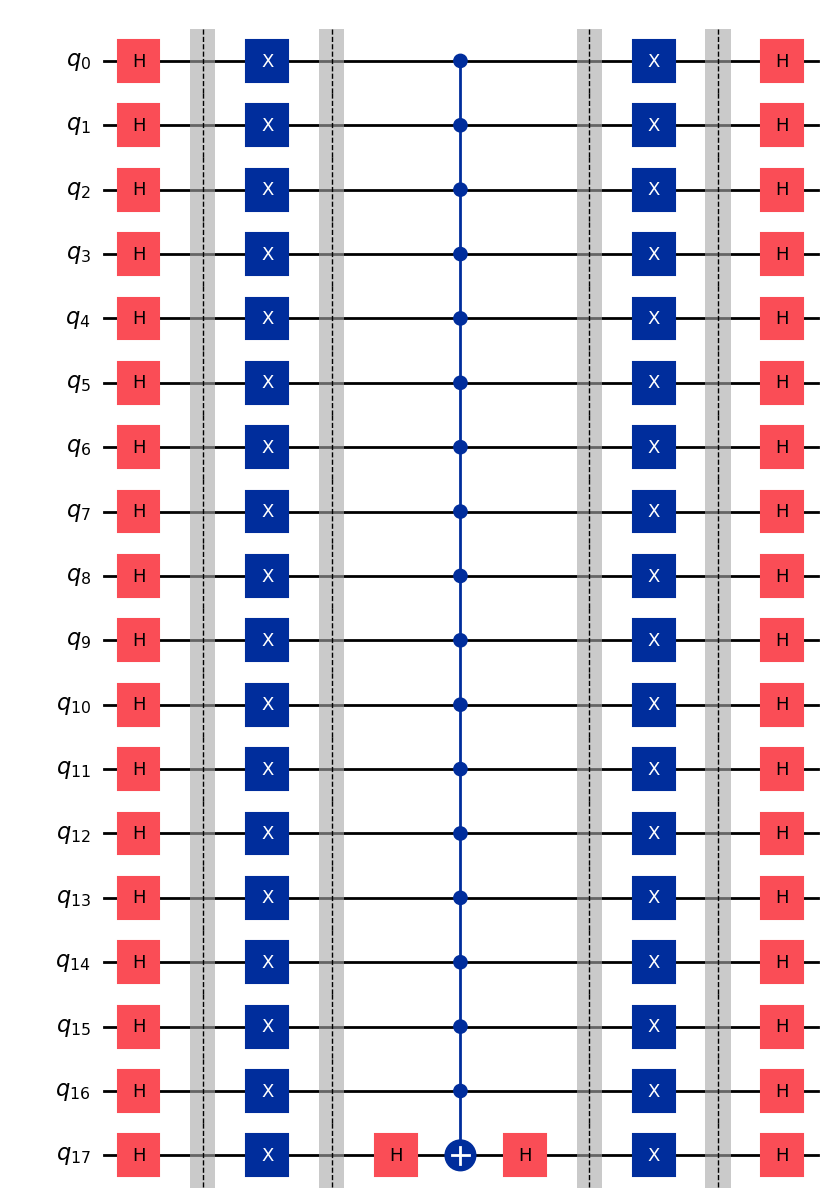

In [12]:
def diffuser(n):
    """Create an n-qubit Grover diffuser (inversion about the mean)."""
    qc = QuantumCircuit(n, name="Diffuser")

    # Step 1: Apply H to all qubits
    qc.h(range(n))
    qc.barrier()
    # Step 2: Apply X to all qubits
    qc.x(range(n))

    # Step 3: Multi-controlled Z (using H + MCX + H trick)

    qc.barrier()
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)  # control on all but last
    qc.h(n - 1)
    qc.barrier()

    # Step 4: Apply X to all qubits
    qc.x(range(n))

    # Step 5: Apply H to all qubits
    qc.barrier()
    qc.h(range(n))

    return qc
ex = diffuser(18)
ex.draw(output='mpl')

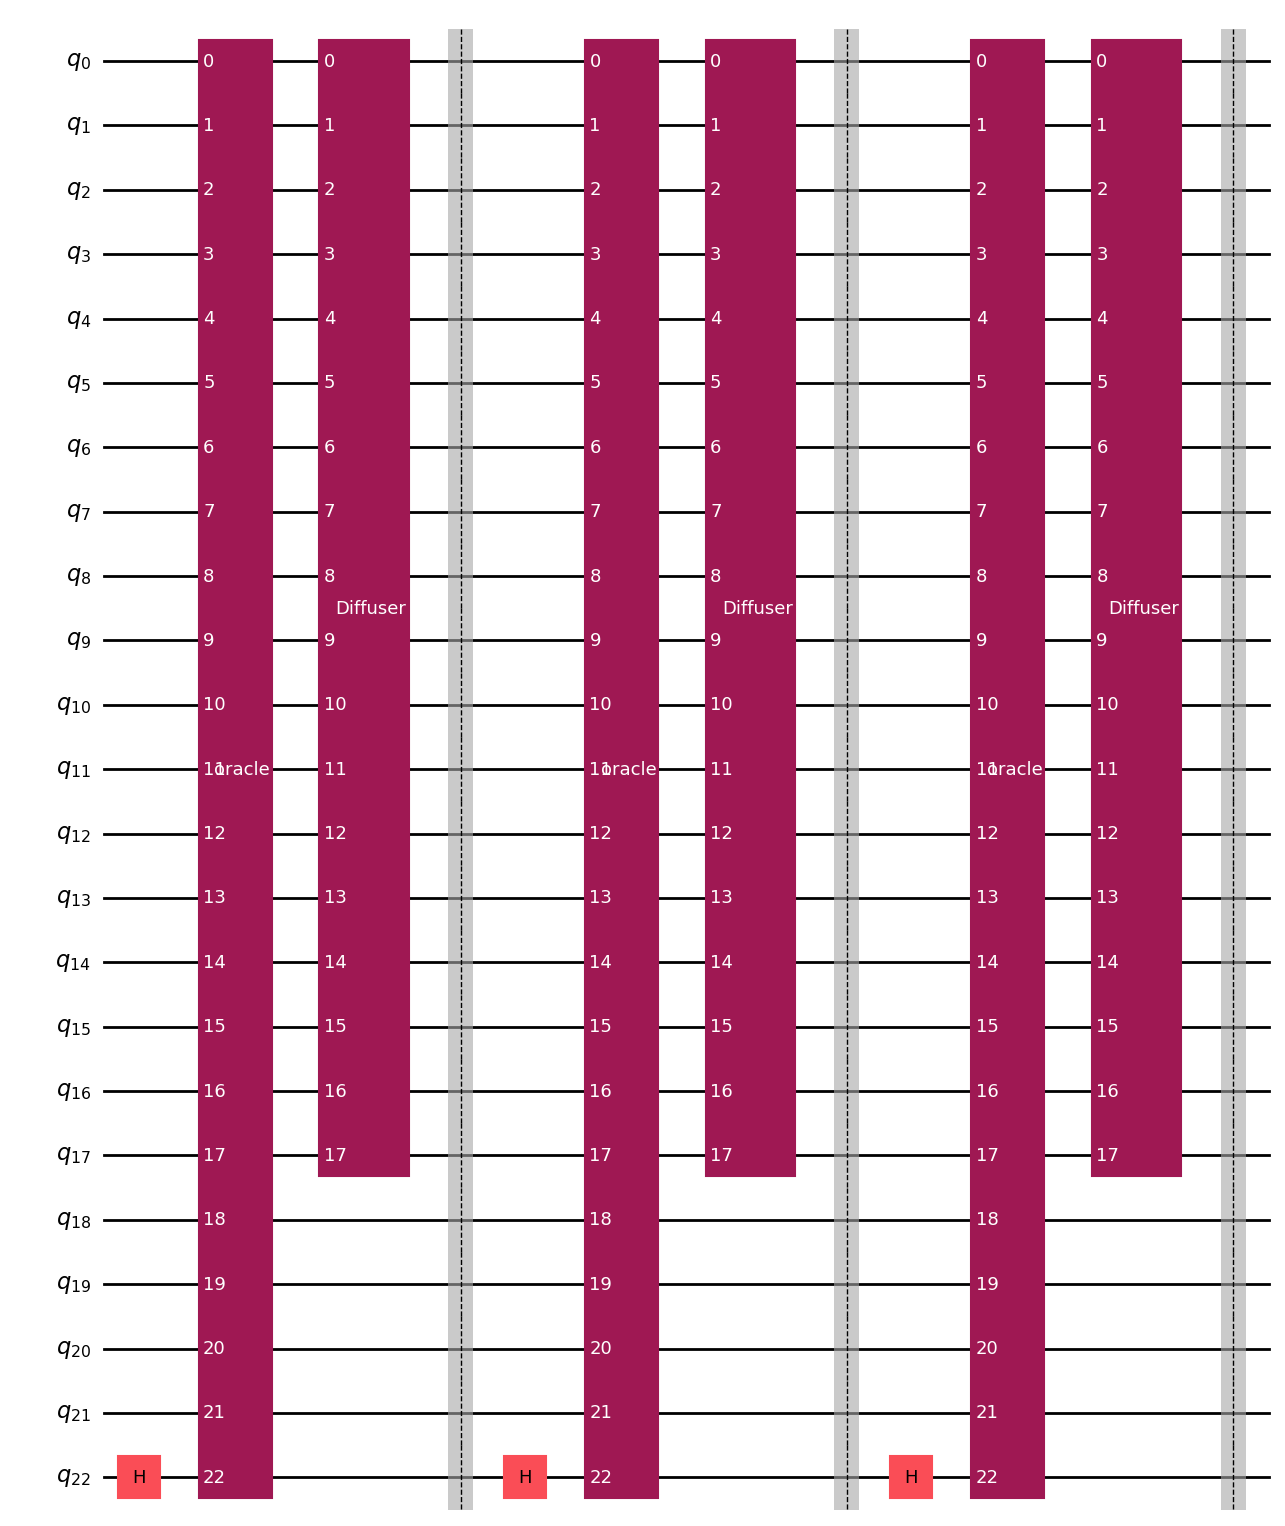

In [13]:
def Grover_algorithm(iterations):
  qc = QuantumCircuit(23,name = "Grover's Algorithm")

  for _ in range(0,iterations):
    qc.h(22)
    qc.append(oracle(),list(range(23)))
    qc.append(diffuser(18),list(range(18)))
    qc.barrier();
  return qc

# For exmaple I am choosing 3 iterations of Grover's Algorithm
qc_ex = Grover_algorithm(3)
qc_ex.draw(output='mpl')

In [14]:
# Preparing the quantum circuit with 23 qubit and 18 bits for storing the mesuared values
qc_main = QuantumCircuit(23,18)
qc_main.reset(list(range(23)))

# This will create all the possiblity of TIc Tac Toe Game
qc_main.h(range(18))

# Just to prepare the ancilla qubit for the grover's algorithm. THis step here will make the |-> state which is necceasry for the phase kick back
qc_main.x(22)

# Applying the grover's iteration for 50 times.
qc_main.append(Grover_algorithm(100),list(range(23)))

# Measure the qubits and save to classical bits
qc_main.measure(list(range(18)), list(range(18)))
qc_main.draw(output="mpl")

# Simulate
simulator = Aer.get_backend('qasm_simulator')
compiled = transpile(qc_main, simulator)
job = simulator.run(compiled, shots=1)
result = job.result()
counts = result.get_counts()

# Output
print("Measurement Results:", counts)
plot_histogram(counts)
plt.show()

Measurement Results: {'111001000100000110': 1}


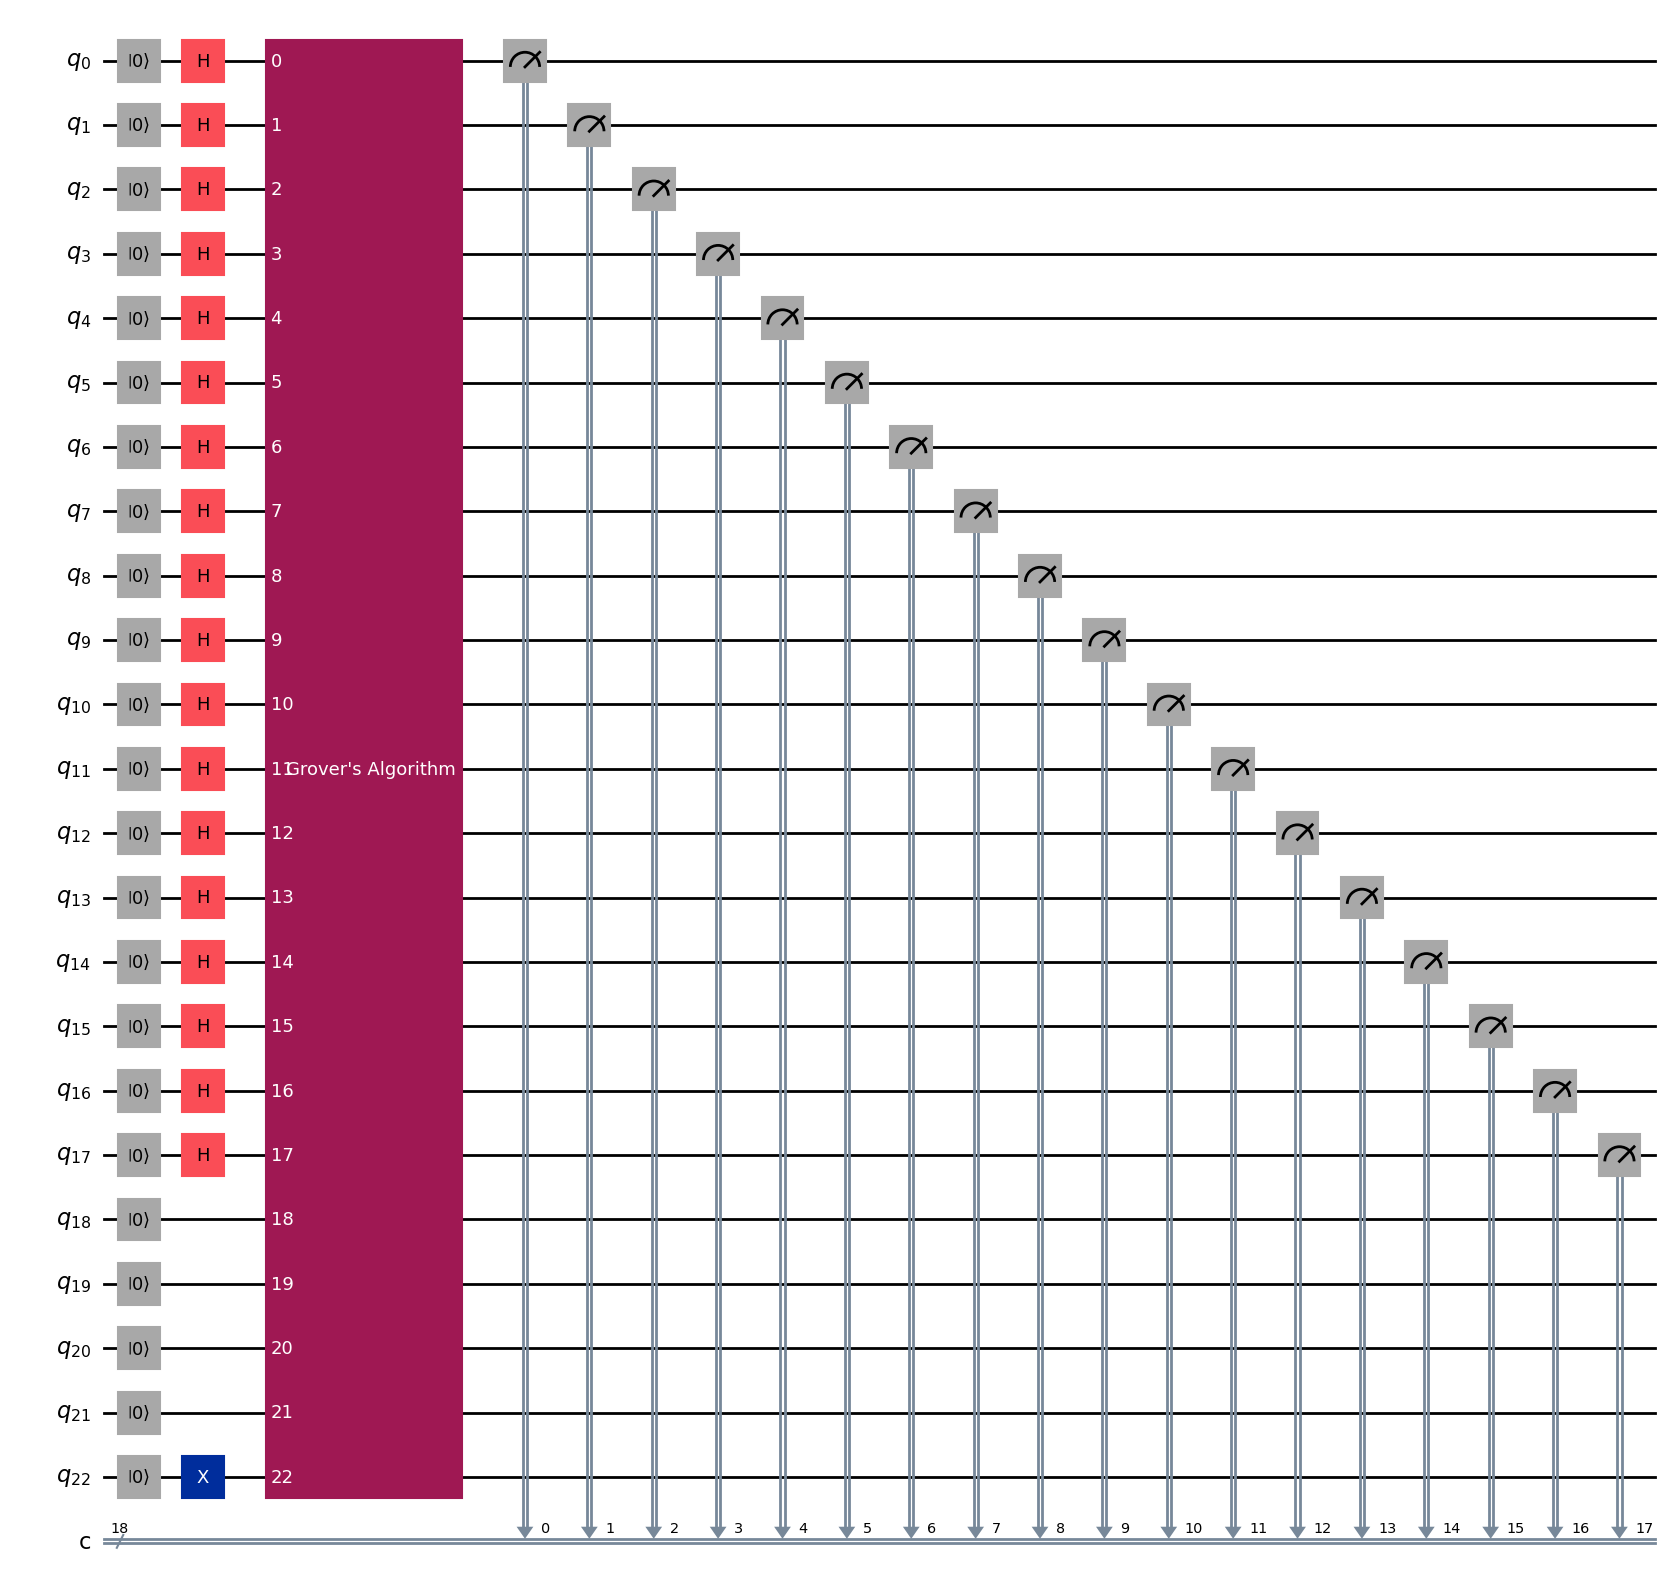

In [15]:
qc_main.draw(output="mpl")